## Tiltmeter - Longterm TROMY und TRII

### Import Libraries

In [1]:
import os
import matplotlib.pyplot as plt

from numpy import arange, linspace, sqrt, diff, nan, gradient, nanmax, deg2rad
from pandas import read_csv, DataFrame, date_range
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from numpy.ma import filled, isMaskedArray, masked
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from obspy import UTCDateTime, read, Stream

# from andbro__querrySeismoData import __querrySeismoData
# from andbro__get_seconds import __get_seconds
from andbro__readYaml import __readYaml
# from andbro__get_timeaxis import __get_timeaxis
from andbro__savefig import __savefig

In [2]:
if os.uname().nodename == "lighthouse":
    root_path = "/home/andbro/"
    data_path = "/home/andbro/kilauea-data/"
elif os.uname().nodename == "kilauea":
    root_path = "/home/brotzer/"
    data_path = "/import/kilauea-data/"
    archive_path = "/import/freenas-ffb-01-data/"

### Configurations

In [3]:
## configurations
config={}

path = f"{root_path}Desktop/tiltmeter/"
# path2 = '/home/andbro/Desktop/tiltmeter/WETTER/*ex'

config['save'] = False


# config['seed_id'] = ["BW.TROMY..MA*", "BW.DROMY..LA*"]
config['seed_id'] = ["BW.TROMY..MA*", "BW.TROMY..MA*"]

config['repository'] = "local"

## local archive
config['datapath'] =  f"{archive_path}romy_archive/"

## resampled data
config['datapath'] =  f"{data_path}TiltmeterDataBackup/Tilt_downsampled/"

## specify output directory for figures
config['output_figures'] = f"{root_path}Documents/ROMY/tiltmeter/figures/"


## long period
config['tbeg'] = UTCDateTime("2021-03-05 00:00")
config['tend'] = UTCDateTime("2022-12-01 00:00")
# config['tend'] = UTCDateTime("2022-04-15 00:00")


## gain for Temperature channel of PT was not set correctly prior to 2021-03-03
correct_settings_temp_PT = ("2021-03-05", config['tend'])

## tiltmeter configurations
confTilt = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter.conf")

## correction of offset (e.g. reset mass)
offset_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/", "tiltmeter_steps.yml")

## correction for temperature trend
temperature_correction = __readYaml(f"{root_path}Documents/ROMY/tiltmeter/","tiltmeter_temperature_correction.yml")


### Define Functions

In [4]:
def __plot_all_tilt(st1, st2, st3):

    from datetime import datetime
    
    NN=3
    
    fig, ax = plt.subplots(NN,1, figsize=(15,8), sharex=True)

    font = 14
    
    tilt_scaling, tilt_unit = 1e-6, r"$\mu$rad"
    time_scaling, time_unit = 86400, "days"
    
    ax[0].plot(st1.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*N")[0].data/tilt_scaling, label="TROMY")
    ax[0].plot(st2.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*N")[0].data/tilt_scaling, label="ROMYT")
    ax[0].plot(st3.select(channel="*N")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*N")[0].data/tilt_scaling, label="BROMY")

    ax[1].plot(st1.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st2.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*E")[0].data/tilt_scaling)
    ax[1].plot(st3.select(channel="*E")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*E")[0].data/tilt_scaling)

    ax[2].plot(st1.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st1.select(channel="*T")[0].data)
    ax[2].plot(st2.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st2.select(channel="*T")[0].data)
    ax[2].plot(st3.select(channel="*T")[0].times(reftime=UTCDateTime("2019-01-01T00"))/time_scaling, 
               st3.select(channel="*T")[0].data)

    ax[0].set_ylabel(f"N ({tilt_unit})", fontsize=font)
    ax[1].set_ylabel(f"E ({tilt_unit})", fontsize=font)
    ax[2].set_ylabel(f"T (°C)", fontsize=font)
#     ax[2].set_xlabel(f"Time ({time_unit})", fontsize=font)
    
    for o in range(3):
        ax[o].grid()
    
    ax[0].legend(loc=1, fontsize=font-2, bbox_to_anchor=(0.7, 1.1), ncol=3, framealpha=1)
    
    tcks= ax[NN-1].get_xticks()
    tcklbls = [datetime.fromtimestamp(t*time_scaling+datetime(2019,1,1).timestamp()).strftime("%Y-%m-%d") for t in tcks]
    ax[NN-1].set_xticklabels(tcklbls)
    
    plt.show();
    return fig  

In [5]:
def __makeplot(pt, bt, config):
    
    fig, axes = plt.subplots(3,2, figsize=(15,5), sharex=True)
    
    font = 14
    
    pt.sort()
    bt.sort()

    for i in range(3):
        
        axes[i,0].plot(pt[i].times(reftime=UTCDateTime("2019-01-01T00"))/3600, pt[i].data, label=pt[i].stats.channel)
        axes[i,1].plot(bt[i].times(reftime=UTCDateTime("2019-01-01T00"))/3600, bt[i].data, label=pt[i].stats.channel)
        
        axes[i,0].grid()
        axes[i,1].grid()
        
        axes[i,0].legend(loc=1)
        axes[i,1].legend(loc=1)
        
        axes[i,0].ticklabel_format(axis="y", style="sci", scilimits=(0,0))
        axes[i,1].ticklabel_format(axis="y", style="sci", scilimits=(0,0))

    axes[2,0].ticklabel_format(axis="y", style="plain")
    axes[2,1].ticklabel_format(axis="y", style="plain")    
        
    axes[2,0].set_xlabel("Time (hours)", fontsize=font)
    axes[2,1].set_xlabel("Time (hours)", fontsize=font)
    
    axes[0,0].set_ylabel("E (rad)", fontsize=font)
    axes[1,0].set_ylabel("N (rad)", fontsize=font)
    axes[2,0].set_ylabel("Temp (°C)", fontsize=font)
    
    axes[0,0].set_title(f"{pt[0].stats.station}")
    axes[0,1].set_title(f"{bt[0].stats.station}")
    
    return fig 

In [6]:
def __conversion(st, conf):

    st0 = st.copy()
    
    def convertTemp(trace):
        Tvolt = trace.data * conf.get('gainTemp')
        coeff = conf.get('calcTempCoefficients')
        return coeff[0] + coeff[1]*Tvolt + coeff[2]*Tvolt**2 + coeff[3]*Tvolt**3
    
    def convertTilt(trace, conversion, sensitivity):
        return trace.data * conversion * sensitivity

    for tr in st0:
        if tr.stats.channel[-1] == 'T':
            tr.data = convertTemp(tr)
        elif tr.stats.channel[-1] == 'N':
            tr.data = convertTilt(tr, conf['convTN'], conf['gainTilt'])
        elif tr.stats.channel[-1] == 'E':
            tr.data = convertTilt(tr, conf['convTE'], conf['gainTilt'])
        else:
            print("no match")
            
    print(f"  -> converted data of {st[0].stats.station}")
    return st0

In [7]:
def __load_local(config, seed_id):
    
    from tqdm.notebook import tqdm
    from obspy.clients.filesystem.sds import Client
    
    net, sta, loc, cha = seed_id.split(".")
    
    tbeg, tend = config['tbeg'], config['tend']

    st0 = Client(config['datapath'],fileborder_samples=1000).get_waveforms(net, sta, loc, cha, tbeg, tend)
    
    st0.merge()
    
    return st0

In [8]:
def __correct_offsets(st, offset_correction, plot=False):
    
    from numpy import nanmedian, nanmean
    from obspy import UTCDateTime, Stream
    
    st_out = Stream()
    
    for cc in ["N", "E", "T"]:

        if cc not in offset_correction.keys():
            st_out += st.select(channel=f"*{cc}").copy()
            continue
        
        st0 = st.select(channel=f"*{cc}").copy()

        tbeg, tend = st0[0].stats.starttime, st0[0].stats.endtime
        
        for nn in range(len(offset_correction[cc])):
            nn +=1

            if offset_correction[cc][nn]['time_reset'] < tbeg or offset_correction[cc][nn]['time_reset'] > tend:
                continue
                        
            step_time = UTCDateTime(offset_correction[cc][nn]['time_reset'])
            offset_time_before = offset_correction[cc][nn]['time_before']
            offset_time_after = offset_correction[cc][nn]['time_after']

            st0_before = st0.copy()
            st0_before.trim(tbeg, step_time-offset_time_before)

            st0_after  = st0.copy()
            st0_after.trim(step_time+offset_time_after, tend)    

            median_before = nanmean(st0_before[0].data[-100:])
            median_after  = nanmean(st0_after[0].data[:100]) 
            
            
            if (median_after - median_before) < 0: 
                st0_after[0].data += abs(median_after - median_before)
            elif (median_after - median_before) >= 0: 
                st0_after[0].data -= abs(median_after - median_before)

            st0_before += st0_after
            
            st0 = st0_before.merge(fill_value=nan)

        st_out += st0
        
#     st_out.trim(tbeg, tend, nearest_sample=False)

    if plot:
        fig, ax = plt.subplots(3,1, figsize=(15,8), sharex=True)

        ax[0].plot(st.select(channel="*N")[0].times()/86400, st.select(channel="*N")[0].data)
        ax[0].plot(st_out.select(channel="*N")[0].times()/86400, st_out.select(channel="*N")[0].data)

        ax[1].plot(st.select(channel="*E")[0].times()/86400, st.select(channel="*E")[0].data)
        ax[1].plot(st_out.select(channel="*E")[0].times()/86400, st_out.select(channel="*E")[0].data)

        ax[2].plot(st.select(channel="*T")[0].times()/86400, st.select(channel="*T")[0].data)
        ax[2].plot(st_out.select(channel="*T")[0].times()/86400, st_out.select(channel="*T")[0].data)

        ax[0].set_ylabel("MAN (counts)")
        ax[1].set_ylabel("MAE (counts)")
        ax[2].set_ylabel("MAT (counts)")
        ax[2].set_xlabel("Time (days)")
        
        plt.show();


    return st_out


### Load Tiltmeter Data

3 Trace(s) in Stream:
BW.TROMY..MAE | 2021-03-05T00:09:59.955000Z - 2022-11-30T23:49:59.955000Z | 600.0 s, 91583 samples (masked)
BW.TROMY..MAN | 2021-03-05T00:09:59.955000Z - 2022-11-30T23:49:59.955000Z | 600.0 s, 91583 samples (masked)
BW.TROMY..MAT | 2021-03-05T00:09:59.955000Z - 2022-11-30T23:49:59.955000Z | 600.0 s, 91583 samples (masked)


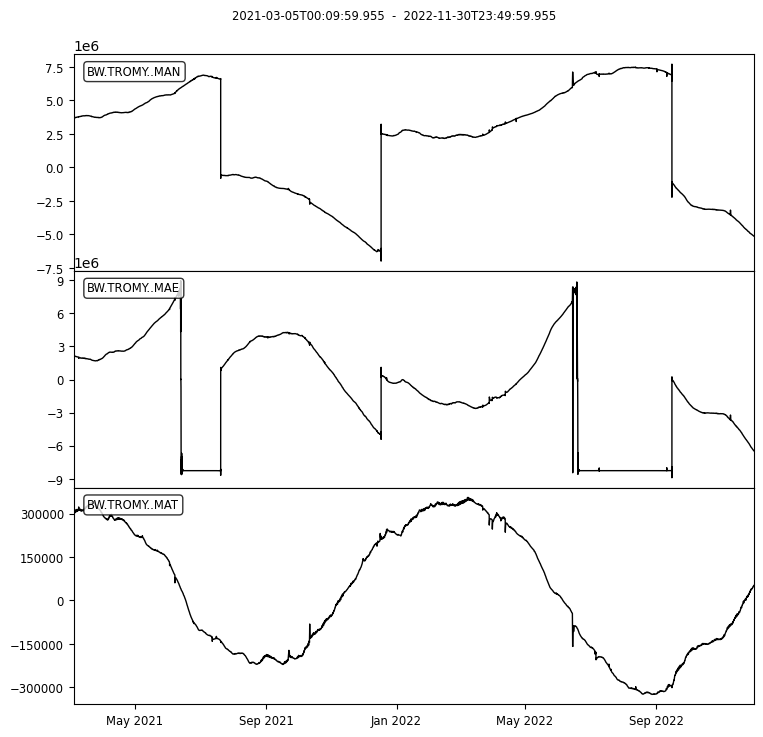

In [9]:
TROMY0 = __load_local(config, "BW.TROMY..MA*")
print(TROMY0)
TROMY0.plot(equal_scale=False);

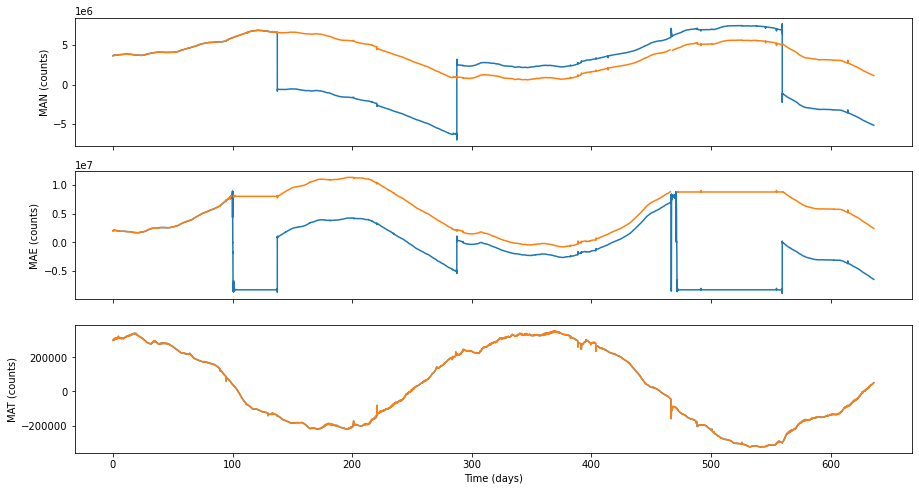

In [10]:
TROMY = __correct_offsets(TROMY0, offset_correction['TROMY'], plot=True)

3 Trace(s) in Stream:
BW.ROMYT..MAE | 2022-04-12T15:44:07.140000Z - 2022-12-01T00:04:07.140000Z | 600.0 s, 33459 samples (masked)
BW.ROMYT..MAN | 2022-04-12T15:44:07.140000Z - 2022-12-01T00:04:07.140000Z | 600.0 s, 33459 samples (masked)
BW.ROMYT..MAT | 2022-04-12T15:44:07.140000Z - 2022-12-01T00:04:07.140000Z | 600.0 s, 33459 samples (masked)


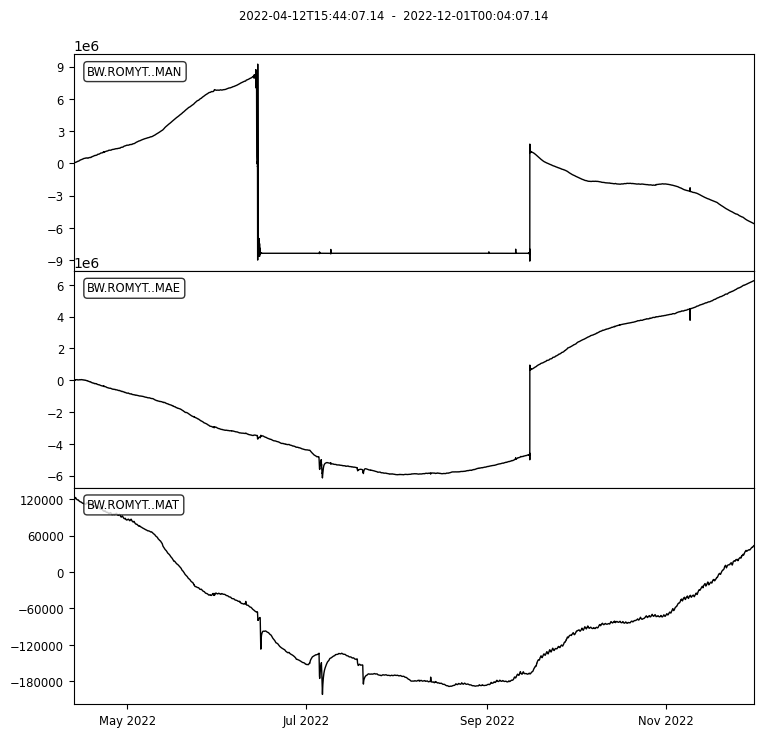

In [11]:
ROMYT0 = __load_local(config, "BW.ROMYT..MA*")
print(ROMYT0)
ROMYT0.plot(equal_scale=False);

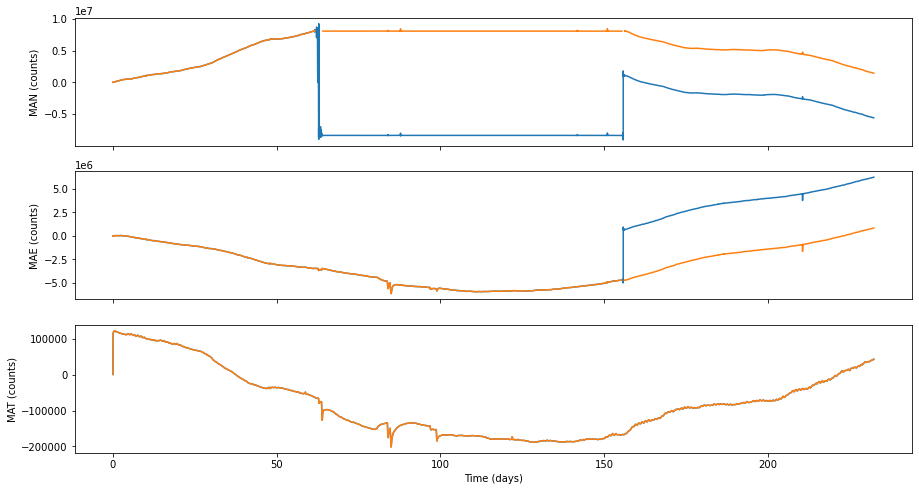

In [12]:
ROMYT = __correct_offsets(ROMYT0, offset_correction['ROMYT'], plot=True)

3 Trace(s) in Stream:
BW.DROMY..LAE | 2021-03-05T00:00:00.000000Z - 2022-12-01T00:00:00.000000Z | 600.0 s, 91585 samples (masked)
BW.DROMY..LAT | 2021-03-05T00:00:00.000000Z - 2022-12-01T00:00:00.000000Z | 600.0 s, 91585 samples (masked)
BW.DROMY..LAN | 2021-03-05T00:00:00.000000Z - 2022-12-01T00:00:00.000000Z | 600.0 s, 91585 samples (masked)


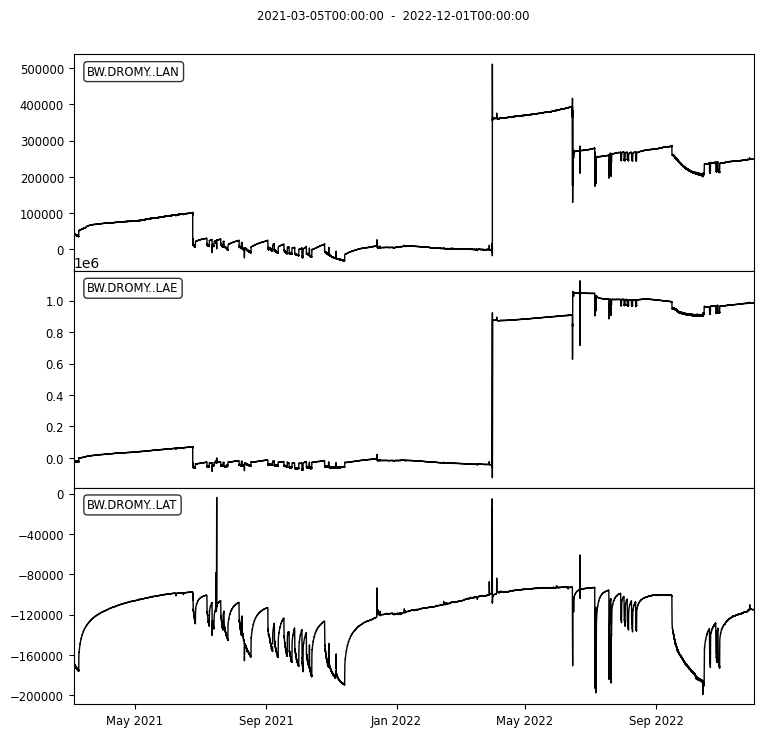

In [13]:
BROMY0 = __load_local(config, "BW.DROMY..LA*")
print(BROMY0)
BROMY0.plot(equal_scale=False);

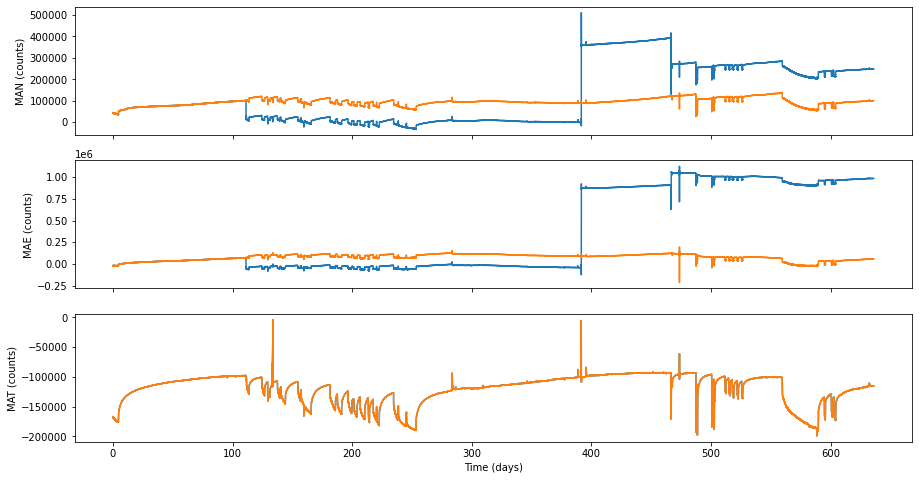

In [14]:
BROMY = __correct_offsets(BROMY0, offset_correction['BROMY'], plot=True)

### Cut useful Borehole Data ... when no dehumidifier!

In [15]:
BROMY.trim(UTCDateTime("2021-12-15"), UTCDateTime("2022-06-01"))

3 Trace(s) in Stream:
BW.DROMY..LAN | 2021-12-15T00:00:00.000000Z - 2022-06-01T00:00:00.000000Z | 600.0 s, 24193 samples (masked)
BW.DROMY..LAE | 2021-12-15T00:00:00.000000Z - 2022-06-01T00:00:00.000000Z | 600.0 s, 24193 samples (masked)
BW.DROMY..LAT | 2021-12-15T00:00:00.000000Z - 2022-06-01T00:00:00.000000Z | 600.0 s, 24193 samples (masked)

### Remove clipped Times

In [16]:
def __cutout(st, channel, tbeg, tend):

    
    st0 = st.copy()
    
    starttime = st0.select(channel=f"*{channel}")[0].stats.starttime
    endtime   = st0.select(channel=f"*{channel}")[0].stats.endtime
    
    tmp = st0.copy()
    newE1 = tmp.select(channel=f"*{channel}").trim(starttime, UTCDateTime(tbeg))
    tmp = st0.copy()
    newE2 = tmp.select(channel=f"*{channel}").trim(UTCDateTime(tend), endtime)
    newE1 += newE2
    newE1.merge()

    st0.select(channel=f"*{channel}")[0].data = newE1[0].data

    return st0

In [17]:
TROMY = __cutout(TROMY, "E", "2022-06-16 00:00:00", "2022-09-15 12:00:00")
ROMYT = __cutout(ROMYT, "N", "2022-06-14 12:00:00", "2022-09-15 12:00:00")

In [18]:
# test_zoom = BROMY0.copy()

# # test_zoom.trim(UTCDateTime("2021-06-24 00:00"), UTCDateTime("2021-06-25 00:00"))
# test_zoom.trim(UTCDateTime("2021-06-24 08:00")-5*3600,UTCDateTime("2021-06-24 08:00")+10*3600)

# test_zoom.plot(equal_scale=False);

### Data Conversion: Count -> Rad

In [19]:
TROMY = __conversion(TROMY, confTilt['ROMYT'])
ROMYT = __conversion(ROMYT, confTilt['ROMYT'])
BROMY = __conversion(BROMY, confTilt['BROMY'])

  -> converted data of TROMY
  -> converted data of ROMYT
  -> converted data of DROMY


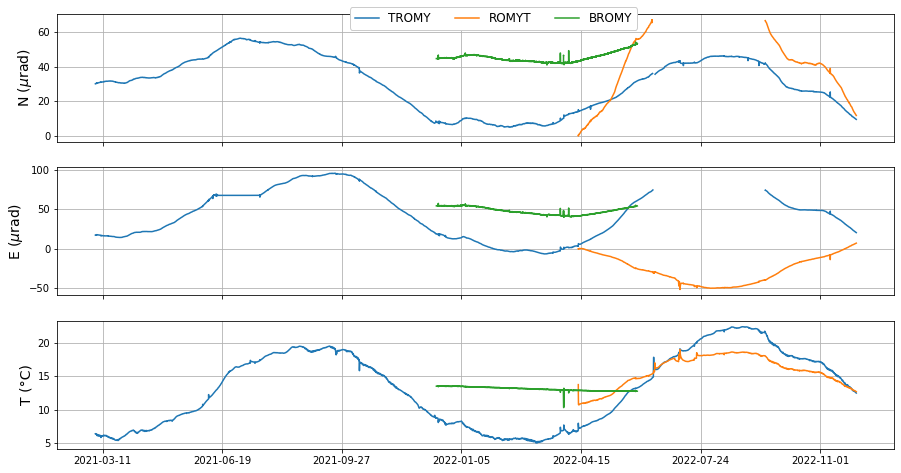

In [20]:
fig = __plot_all_tilt(TROMY, ROMYT, BROMY)   

In [21]:
# __savefig(fig, outpath=config['output_figures'], outname="Tiltmeter_ALL_preprocessed", mode="png", dpi=None)

### Correct Temperature Trend

In [22]:
def __correct_temperature_trend(st, correction, relative=False):
    
    st0 = st.copy()
    temperature = st0.select(channel="*T")[0].data

    if relative: 
        temperature -= temperature[0]
    
#     st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
#     st0.select(channel="*E")[0].data -= (correction['N_slope']* temperature + correction['N_intercept'])
    st0.select(channel="*N")[0].data -= (correction['N_slope']* temperature)
    st0.select(channel="*E")[0].data -= (correction['E_slope']* temperature)   
    
    return st0

In [37]:
TROMY = TROMY.split().merge(fill_value=nan)
ROMYT = ROMYT.split().merge(fill_value=nan)
BROMY = BROMY.split().merge(fill_value=nan)

In [45]:
TROMY_tc = __correct_temperature_trend(TROMY, temperature_correction['TROMY'], relative=True)
ROMYT_tc = __correct_temperature_trend(ROMYT, temperature_correction['ROMYT'], relative=True)
# BROMY_tc = __correct_temperature_trend(BROMY, temperature_correction['BROMY'], relative=True)
BROMY_tc = BROMY

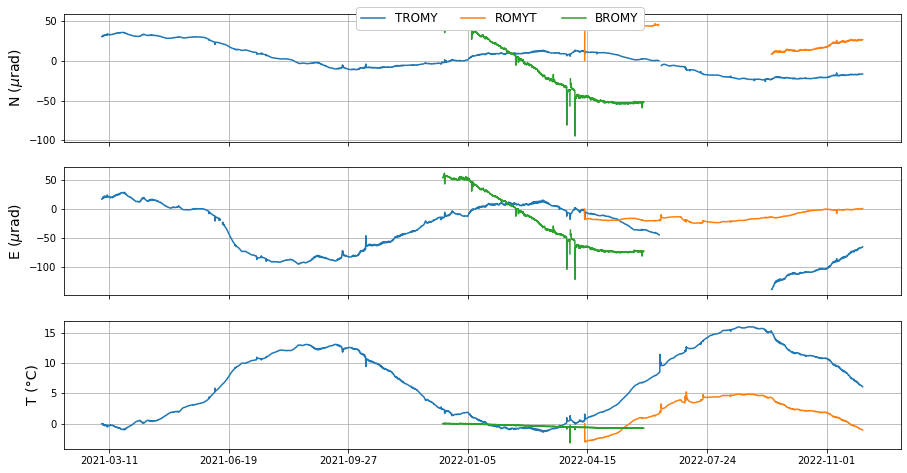

In [39]:
fig = __plot_all_tilt(TROMY_tc, ROMYT_tc, BROMY_tc)

## Store Data

In [46]:
# st_out = Stream()

# st_out += TROMY_tc
# st_out += ROMYT_tc
# st_out += BROMY_tc

# st_out.write("tilt_all_Tcorrect.mseed")

## Compare with PSD

Check if earth tides are visible

In [ ]:
st_new = Stream()
st_new += TRII.select(channel="*N")
st_new += TRII.select(channel="*E")

st_new += TROMY.select(channel="*N").split()
st_new += TROMY.select(channel="*E").split()

st_new.merge(method=1, fill_value='interpolate')

# st_new.trim(config['tbeg'], config['tend']-3*86400)
# st_new.detrend("linear")
# st_new.filter("bandpass", freqmin=1e-7, freqmax=1e-5, corners=4, zerophase=True)

In [ ]:
def __makeplotStreamPSD(st, config):

    from scipy import fftpack
    from numpy import log10, nanmax, nanmin
    from scipy.signal import welch, hann


    nblock =  4096
    overlap = None
    win = hann(nblock, True)

    NN = len(st)
    
    fig, axes = plt.subplots(NN,2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

        ff, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, 
                        window=win, noverlap=overlap, nfft=nblock,
                        scaling="density",
                        return_onesided=True)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/86400,
                    tr.data*1e6,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].loglog(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )
        
        Pxx_max, Pxx_min = nanmax(Pxx), nanmin(Pxx)
        
        axes[i,1].vlines(1/86400, Pxx_min, Pxx_max, color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400, Pxx_min, Pxx_max, color="darkgrey", alpha=1.0, zorder=0)
        
        axes[NN-1,0].set_xlabel("Time (days)")
        axes[NN-1,1].set_xlabel("Frequency (Hz)")
        
        axes[i,1].set_ylim(Pxx_min, Pxx_max)
        
        axes[i,0].set_ylabel(r'$\Omega$ ($\mu$rad)')    
        axes[i,1].set_ylabel(r'PSD (rad$^2$/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
        
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

        axes[i,1].set_xlim(1e-6,0.25)

    
    
    return fig

In [ ]:
# __makeplotStreamPSD(st_new, config);

In [ ]:
def __makeplotStreamSpectra(st, config):

    from scipy import fftpack
    from numpy import abs

    NN = len(st)

    fig, axes = plt.subplots(NN,2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

        comp_fft = abs(fftpack.fft(tr.data))
        ff       = fftpack.fftfreq(comp_fft.size, d=1/tr.stats.sampling_rate)
        comp_fft = fftpack.fftshift(comp_fft)


        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/86400,
                    tr.data*1e6,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        fxx = abs(fftpack.fft(tr.data)[1:len(ff)//2])
        axes[i,1].loglog(
                    ff[1:len(ff)//2],
                    fxx,
                    color='black',
                    lw=1.0,
                    )
        
        axes[i,1].vlines(1/86400,min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400,min(fxx[:]), max(fxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        
        axes[NN-1,0].set_xlabel("Time (days)")
        axes[NN-1,1].set_xlabel("Frequency (Hz)")
                      
        axes[i,0].set_ylabel(r'$\Omega$ ($\mu$rad)')    
        axes[i,1].set_ylabel(r'ASD (rad/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].set_xlim(1e-7,0.25)
#         axes[i,1].set_ylim(1e-12,1e-9)

    return fig

In [ ]:
# fig = __makeplotStreamSpectra(st_new, config);

In [ ]:
def __makeplotStreamPSD2(st, config):

    from scipy import fftpack
    from numpy import abs, log10
    from scipy.signal import welch, hann


    nblock =  4096*1000
    overlap = 1028
    win = hann(nblock, True)

    NN = len(st)
    
    fig, axes = plt.subplots(NN,2,figsize=(15,10), sharex='col')

    plt.subplots_adjust(hspace=0.3)

    ## _______________________________________________

    st.sort(keys=['channel'], reverse=True)
    
    for i, tr in enumerate(st):

        ff, Pxx = welch(tr.data, fs=tr.stats.sampling_rate, 
                        window=win, noverlap=overlap, nfft=nblock,
                        scaling="density",
                        return_onesided=True)

        ## _________________________________________________________________
        axes[i,0].plot(
                    tr.times()/86400,
                    tr.data*1e6,
                    color='black',
                    label='{} {}'.format(tr.stats.station, tr.stats.channel),
                    lw=1.0,
                    )


        ## _________________________________________________________________
        axes[i,1].loglog(
                    ff,
                    Pxx,
                    color='black',
                    lw=1.0,
                    )
        
        axes[i,1].vlines(1/86400,min(Pxx[:]), max(Pxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        axes[i,1].vlines(2/86400,min(Pxx[:]), max(Pxx[:]), color="darkgrey", alpha=1.0, zorder=0)
        
        axes[NN-1,0].set_xlabel("Time (days)")
        axes[NN-1,1].set_xlabel("Frequency (Hz)")
        
        axes[i,1].set_ylim(min(Pxx[:]), max(Pxx[:]))
        
        axes[i,0].set_ylabel(r'$\Omega$ ($\mu$rad)')    
        axes[i,1].set_ylabel(r'PSD (rad$^2$/Hz)')        
        axes[i,0].legend(loc='upper left',bbox_to_anchor=(0.8, 1.10), framealpha=1.0)
#         axes[i,0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
#         axes[i,1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        axes[i,1].set_xlim(1e-7,1e-4)

    
    
    return fig

# __makeplotStreamPSD2(TROMY_long, config);

In [ ]:
# fig = __makeplotStreamPSD2(TROMY_long_corrected, config);

## Tilt Vector

In [ ]:
def __get_movement(N, E, Twin=3600):

    from numpy import median, sqrt, arctan, degrees, mod, array, append, rad2deg, nan
    from numpy import ma
    
    dt = N[0].stats.delta
#     t1 = N[0].stats.starttime
    t1 = 0

    Ndata = N[0].data
    Edata = E[0].data

    if ma.is_masked(Ndata):
        Ndata = ma.filled(Ndata, fill_value=nan)
    if ma.is_masked(Edata):
        Edata = ma.filled(Edata, fill_value=nan)
        
    vnorm, vdir, timeline = [], [], []
    while (t1 + Twin) < N[0].stats.npts*dt:
        
        Nmed = median(Ndata[int(t1/dt):int((t1+Twin)/dt)])
        Emed = median(Edata[int(t1/dt):int((t1+Twin)/dt)])

        
        vnorm.append(sqrt(Nmed**2 + Emed**2))
        
        if Nmed > 0 and Emed > 0:
            vdir.append(90-abs(rad2deg(arctan(abs(Nmed/Emed)))))
        
        elif Nmed < 0 and Emed > 0:
            vdir.append(90+abs(rad2deg(arctan(abs(Nmed/Emed)))))
        
        elif Nmed < 0 and Emed < 0:
            vdir.append(270-abs(rad2deg(arctan(abs(Nmed/Emed)))))
        
        elif Nmed > 0 and Emed < 0:
            vdir.append(270+abs(rad2deg(arctan(abs(Nmed/Emed)))))
        
        else:
            vdir.append(nan)
            
        t1 += Twin/2
    
        timeline.append(t1)
    
    time_offset = N[0].stats.starttime.julday
#     timeline = array(timeline)/3600 /24 + time_offset# in days
    timeline = array(timeline)/3600 /24 # in days
    
    return timeline, array(vdir), array(vnorm)

In [ ]:
def __makeplot_normal_vector_movement(vdirH, vnormH, vtimelineH, starttime, title="Tiltmeter"):
    
    from numpy import nanmax, radians
    
    #-- Plot... ------------------------------------------------
    fig, ax = plt.subplots(1,1, subplot_kw=dict(projection='polar'), figsize=(15,5))

    font=12

    p1 = ax.scatter(deg2rad(vdirH), vnormH, c=vtimelineH, cmap='plasma', alpha=0.75, s=4, zorder=2)

    cbar1 = plt.colorbar(p1, ax=ax, pad=0.1)
    cbar1.set_label(f'Time in days from {starttime.date}', rotation=270, fontsize=font, labelpad=18)

    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)

    ax.text(deg2rad(25),max(vnormH)+0.1*max(vnormH),r"$\mu$rad")

    ax.set_rgrids(arange(0, nanmax(vnormH),int(nanmax(vnormH)/5)), angle=60., zorder=0)
    ax.text(radians(ax.get_rlabel_position()+10),ax.get_rmax()/2.,r'Tilt ($\mu$rad)', fontsize=12,rotation=30,ha='center',va='center')
    
    ax.set_title(title,fontsize=font, pad=10)

In [ ]:
## tilt data with temperature variations
# north = BROMY.select(channel="*N").copy()
# east  = BROMY.select(channel="*E").copy()

## temperature corrected data
north = BROMY_tc.select(channel="*N").copy()
east  = BROMY_tc.select(channel="*E").copy()


## __________________

# convert to micro rad
north[0].data *= 1e6
east[0].data *= 1e6

north[0].data -= north[0].data[1]
east[0].data  -= east[0].data[1]

vtimelineH, vdirH, vnormH = __get_movement(north, east, Twin=3600)

starttime = north[0].stats.starttime

__makeplot_normal_vector_movement(vdirH, vnormH, vtimelineH, starttime, title="Tiltmeter: BROMY")

In [ ]:
## tilt data with temperature variations
# north = TROMY.select(channel="*N").copy()
# east  = TROMY.select(channel="*E").copy()

## temperature corrected data
north = TROMY_tc.select(channel="*N").copy()
east  = TROMY_tc.select(channel="*E").copy()

## __________________

# convert to micro rad
north[0].data *= 1e6
east[0].data *= 1e6

north[0].data -= north[0].data[1]
east[0].data  -= east[0].data[1]

vtimelineH, vdirH, vnormH = __get_movement(north, east, Twin=3600)

starttime = north[0].stats.starttime

__makeplot_normal_vector_movement(vdirH, vnormH, vtimelineH, starttime, title="Tiltmeter: TROMY (NE)")

In [ ]:
## tilt data with temperature variations
# north = ROMYT.select(channel="*N").copy()
# east  = ROMYT.select(channel="*E").copy()

## temperature corrected data
north = ROMYT_tc.select(channel="*N").copy()
east  = ROMYT_tc.select(channel="*E").copy()

## __________________

# convert to micro rad
north[0].data *= 1e6
east[0].data *= 1e6

north[0].data -= north[0].data[1]
east[0].data  -= east[0].data[1]

vtimelineH, vdirH, vnormH = __get_movement(north, east, Twin=3600)

starttime = north[0].stats.starttime

__makeplot_normal_vector_movement(vdirH, vnormH, vtimelineH, starttime, title="Tiltmeter: ROMYT (NW)")

In [ ]:
# def __makeplot_normal_vector_movement(vdirH, vnormH, vdirV, vnormV, vtimelineH, vtimelineV):
    
#     #-- Plot... ------------------------------------------------
#     fig, ax = plt.subplots(1,2, subplot_kw=dict(projection='polar'), figsize=(15,5))

#     font=12

#     p1 = ax[0].scatter(deg2rad(vdirH), vnormH, c=vtimelineH, cmap='plasma', alpha=0.75, s=4, zorder=2)
#     p2 = ax[1].scatter(deg2rad(vdirV), vnormV, c=vtimelineV, cmap='plasma', alpha=0.75, s=4, zorder=2)

#     cbar1 = plt.colorbar(p1, ax=ax[0], pad=0.1)
#     cbar1.set_label(f'Time in days from {tbeg.date}', rotation=270, fontsize=font, labelpad=18)

#     cbar2 = plt.colorbar(p2, ax=ax[1],  pad=0.1)
#     cbar2.set_label(f'Time in days from {tbeg.date}', rotation=270, fontsize=font, labelpad=18)


# #     ax[0].set_ylim(min(vnormH)-0.1*min(vnormH), max(vnormH)+0.05*max(vnormH))

# #     ax[1].set_ylim(min(vnormV)-0.05*min(vnormV), max(vnormV)+0.01*max(vnormV))

# #     ax[0].set_ylim(0.15, 0.18)
# #     ax[1].set_ylim(0.2, 0.24)

#     ax[0].set_theta_zero_location('N')
#     ax[0].set_theta_direction(-1)

#     ax[1].set_theta_zero_location('N')
#     ax[1].set_theta_direction(-1)
    
#     ax[0].text(deg2rad(25),max(vnormH)+0.1*max(vnormH),r"$\mu$rad")
#     ax[1].text(deg2rad(25),max(vnormV)+0.1*max(vnormH),r"$\mu$rad")

# #     ax[0].set_rgrids(arange(15, 50, 5), angle=60., zorder=0)
# #     ax[1].set_rgrids(arange(22.5, 40.0, 2.5), angle=60., zorder=0)

#     ax[0].set_title("Tiltmeter TROMY (NE)",fontsize=font)
#     ax[1].set_title("Borehole Tiltmeter",fontsize=font)
# __makeplot_normal_vector_movement(vdirH, vnormH, vdirH, vnormH, vtimelineH, vtimelineH)

In [ ]:
# def __makeplot_vector(vdirH, vnormH, vdirV, vnormV, vtimelineH, vtimelineV):
    
#     N = 2
#     font = 12
 
#     fig, ax = plt.subplots(N, 2, figsize=(15,6), sharex=True)
    
# #     ax[0][0].plot(vtimelineH, vnormH)
#     ax[0][0].scatter(vtimelineH, vnormH, c=vtimelineH, cmap="plasma", s=0.7)
    
# #     ax[0][1].plot(vtimelineV, vnormV)
#     ax[0][1].scatter(vtimelineV, vnormV, c=vtimelineH, cmap="plasma", s=0.7)
    
# #     ax[1][0].plot(vtimelineH, vdirH)
#     ax[1][0].scatter(vtimelineH, vdirH, c=vtimelineH, cmap="plasma", s=0.7)

# #     ax[1][1].plot(vtimelineV, vdirV)
#     ax[1][1].scatter(vtimelineV, vdirV, c=vtimelineH, cmap="plasma", s=0.7)
   
#     ax[0][0].grid(zorder=0, alpha=0.7, color="grey", ls=":")
#     ax[0][1].grid(zorder=0, alpha=0.7, color="grey", ls=":")
#     ax[1][0].grid(zorder=0, alpha=0.7, color="grey", ls=":")
#     ax[1][1].grid(zorder=0, alpha=0.7, color="grey", ls=":")
    
#     ax[0][0].set_title('Tiltmeter TROMY (NE)', fontsize=font)
#     ax[0][1].set_title('Borehole Tiltmeter', fontsize=font)
    
#     ax[0][0].set_ylabel("Vector Norm (mrad)", fontsize=font)
#     ax[1][0].set_ylabel("Degrees (°)", fontsize=font)
    
#     ax[N-1][0].set_xlabel(f"Days from {tbeg.date}", fontsize=font)
#     ax[N-1][1].set_xlabel(f"Days from {tbeg.date}", fontsize=font)
    
#     return fig

In [ ]:
# __makeplot_vector(vdirH, vnormH, vdirH, vnormH, vtimelineH, vtimelineH);